In [42]:
import sys
#!{sys.executable} -m pip install sklearn
import numpy as np
from matplotlib import pyplot as plt
import random
import os
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import spatial
from IPython.display import HTML
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel)
from pypointmatcher import pointmatcher as pm, pointmatchersupport as pms
PM = pm.PointMatcher
DP = PM.DataPoints

import importlib
import scripts.theodolite_function as tfu
import scripts.theodolite_utils as tfuu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.gp_prediction_utils as GPf
GPf = importlib.reload(GPf)

#1 11 2021
Dist_prism_12 = 1.0398341231585624*1000
Dist_prism_13 = 0.818424700118086*1000
Dist_prism_23 = 0.8806156053859284*1000
Dist_GPS_12 = 0.835637436093363*1000
Dist_GPS_13 = 0.7812173648662254*1000
Dist_GPS_23 = 0.5166745729506486*1000

Number of data for theodolites: [1201 1182 1181]
Bad measures: 50


<IPython.core.display.Javascript object>


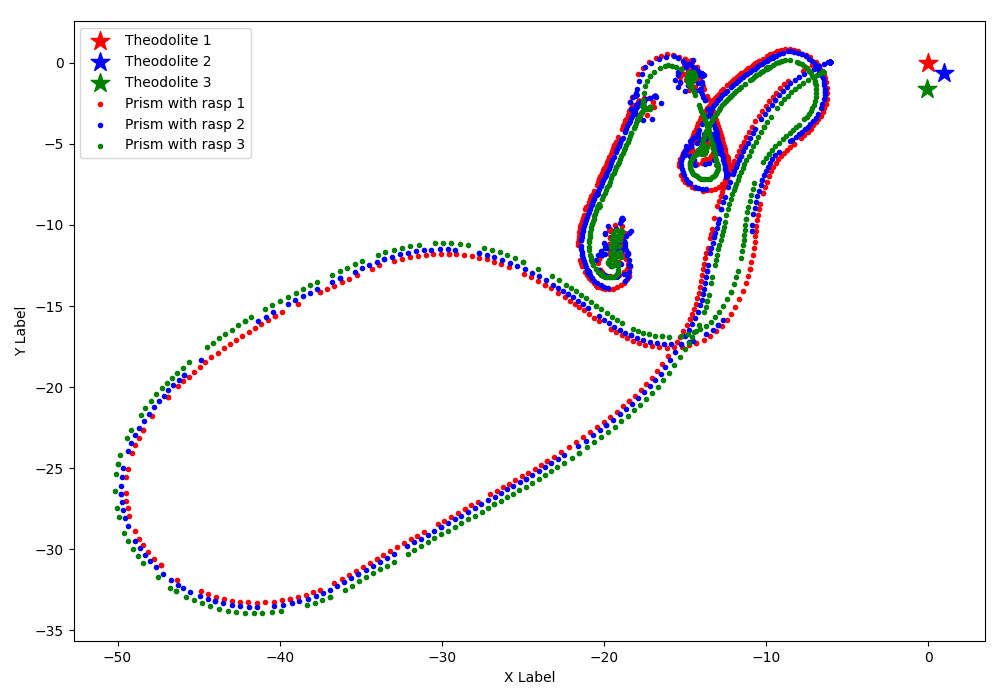

In [57]:
# Test with real data
###################################################################################
tfu = importlib.reload(tfu)

# Read markers file of grand axe and show them
tfu = importlib.reload(tfu)
file_name = './data/2021_11_16_theodolite_reference_prisms.txt'
trimble_1, trimble_2, trimble_3, T_1_grand, T_2_grand, T_3_grand = tfu.read_marker_file(file_name, 1)
#tfu.plot_trajectories_prism(3, trimble_1, trimble_2, trimble_3, T_1_grand, T_2_grand, T_3_grand, 0, 0,"example.pdf",1)

# Read rosbag of grand axe and show the trajectory
# small loop 1
file = "/media/norlab/Samsung_disk/Data/IROS_2022/Total_station/2021-11-16-15-05-36_filtered.bag"
# small loop 2
#file = "/media/norlab/Samsung_disk/Data/IROS_2022/Total_station/2021-11-16-15-13-53_filtered.bag"
# long bag
#file = "/media/norlab/Samsung_disk/Data/IROS_2022/Total_station/2021-11-16-15-20-59_filtered.bag"
# short bag end
#file = "/media/norlab/Samsung_disk/Data/IROS_2022/Total_station/2021-11-16-16-15-00_filtered.bag"

Tf = []
Tf.append(T_1_grand)
Tf.append(T_2_grand)
Tf.append(T_3_grand)
trajectory_trimble_1, trajectory_trimble_2, trajectory_trimble_3, time_trimble_1, time_trimble_2, time_trimble_3 = tfu.read_rosbag_theodolite_with_tf(file, Tf)
trimble_1 = np.array(trajectory_trimble_1).T
trimble_2 = np.array(trajectory_trimble_2).T
trimble_3 = np.array(trajectory_trimble_3).T

%matplotlib notebook
# Variable to plot in 3d, 0 = 2D, 1 = 3D
plot_3d = 0
# Variable to save file in pdf
save_pdf = 0
# file name to save plot in pdf
file_pdf = "./figs/grand_axe_1.pdf"

tfu.plot_trajectories_prism(3, trimble_1, trimble_2, trimble_3, T_1_grand, T_2_grand, T_3_grand, plot_3d, save_pdf, file_pdf, 1)
            
#Rosbag of imu_node for speed
#tfu = importlib.reload(tfu)
#file = "/home/maxime/theodolites_tests/data_for_processing/ski_trail/2020-10-08-17_58_38_imu_data.bag"
#file = "/home/maxime/theodolites_tests/data_for_processing/ski_trail/2020-10-08-18-01-19_imu_data.bag"
#speed, accel = tfu.read_rosbag_imu_node(file, False, 0)
#print(time_trimble_1[0]-speed[0][0])

Number sub-trajectories: 2


<IPython.core.display.Javascript object>


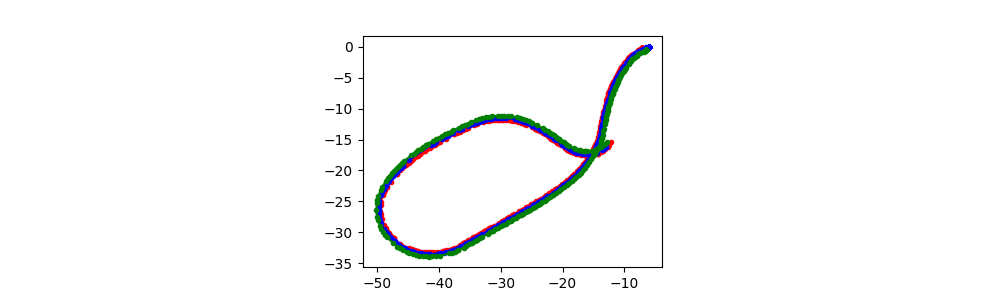

In [58]:
# Work on the data with 3 prisms and 3 theodolites
tfu = importlib.reload(tfu)
# Slipt the data into different interval according to the timestamps of the measurments
limit_time_interval = 4
list_interval, list_time = tfu.split_time_interval_all_data(time_trimble_1, time_trimble_2, time_trimble_3, limit_time_interval)
# Keep only the intervals where the three theodlites have done some measurements at the same time
limit_search = 4
list_trajectories_split = tfu.merge_interval(list_interval, list_time, time_trimble_1, time_trimble_2, time_trimble_3, limit_search)
print("Number sub-trajectories:",len(list_trajectories_split))
# Plot subtrajectory for debug
tfu.plot_subtrajectory_result(0, list_trajectories_split, trimble_1, trimble_2, trimble_3)

In [64]:
GPf = importlib.reload(GPf)  # long !
number_sub = 1
debut_1 = list_trajectories_split[number_sub][:,0]
debut_2 = list_trajectories_split[number_sub][:,1]
debut_3 = list_trajectories_split[number_sub][:,2]
time_1 = time_trimble_1[debut_1[0]:debut_1[1]]
time_2 = time_trimble_2[debut_2[0]:debut_2[1]]
time_3 = time_trimble_3[debut_3[0]:debut_3[1]]
traj_1 = trimble_1[0:3,debut_1[0]:debut_1[1]]
traj_2 = trimble_2[0:3,debut_2[0]:debut_2[1]]
traj_3 = trimble_3[0:3,debut_3[0]:debut_3[1]]

T_1_train = np.atleast_2d(time_1).T
X_1_train = traj_1[0,:].ravel()
Y_1_train = traj_1[1,:].ravel()
Z_1_train = traj_1[2,:].ravel()

T_2_train = np.atleast_2d(time_2).T
X_2_train = traj_2[0,:].ravel()
Y_2_train = traj_2[1,:].ravel()
Z_2_train = traj_2[2,:].ravel()

T_3_train = np.atleast_2d(time_3).T
X_3_train = traj_3[0,:].ravel()
Y_3_train = traj_3[1,:].ravel()
Z_3_train = traj_3[2,:].ravel()

kernel = 6
alpha = 0.002**2
n_restarts_optimizer = 9

gp_x_1 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_1_train, X_1_train)  #alpha = variance
gp_y_1 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_1_train, Y_1_train)
gp_z_1 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_1_train, Z_1_train)

gp_x_2 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_2_train, X_2_train)  
gp_y_2 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_2_train, Y_2_train)
gp_z_2 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_2_train, Z_2_train)

gp_x_3 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_3_train, X_3_train)  
gp_y_3 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_3_train, Y_3_train)
gp_z_3 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_3_train, Z_3_train)


/home/norlab/.local/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/norlab/.local/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/norlab/.local/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/sta

In [65]:
GPf = importlib.reload(GPf)
begin = round(min(time_1[0], time_2[0], time_3[0]))
end = round(max(time_1[-1], time_2[-1], time_3[-1]))
number_pred = (end-begin+1)*20  #20Hz
T_prediction = np.atleast_2d(np.linspace(begin, end, number_pred)).T

x1_pred, sx1_pred = GPf.predict_GP(gp_x_1, T_prediction, True)
y1_pred, sy1_pred = GPf.predict_GP(gp_y_1, T_prediction, True)
z1_pred, sz1_pred = GPf.predict_GP(gp_z_1, T_prediction, True)
x2_pred, sx2_pred = GPf.predict_GP(gp_x_2, T_prediction, True)
y2_pred, sy2_pred = GPf.predict_GP(gp_y_2, T_prediction, True)
z2_pred, sz2_pred = GPf.predict_GP(gp_z_2, T_prediction, True)
x3_pred, sx3_pred = GPf.predict_GP(gp_x_3, T_prediction, True)
y3_pred, sy3_pred = GPf.predict_GP(gp_y_3, T_prediction, True)
z3_pred, sz3_pred = GPf.predict_GP(gp_z_3, T_prediction, True)

<IPython.core.display.Javascript object>


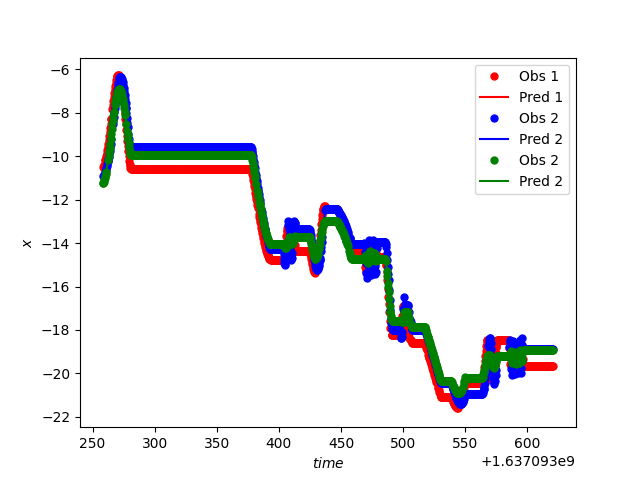

In [67]:
plt.figure(0)
T_train = T_1_train
X_train = X_1_train
x_pred = x2_pred
s_pred = sx2_pred

plt.plot(T_1_train, X_1_train, 'r.', markersize=10, label='Obs 1')
plt.plot(T_prediction, x1_pred, 'r-', label='Pred 1')
plt.fill(np.concatenate([T_prediction, T_prediction[::-1]]),np.concatenate([x1_pred - 1.9600 * sx1_pred,(x1_pred + 1.9600 * sx1_pred)[::-1]]),
         alpha=.5, fc='r', ec='None')

plt.plot(T_2_train, X_2_train, 'b.', markersize=10, label='Obs 2')
plt.plot(T_prediction, x2_pred, 'b-', label='Pred 2')
plt.fill(np.concatenate([T_prediction, T_prediction[::-1]]),np.concatenate([x2_pred - 1.9600 * sx2_pred,(x2_pred + 1.9600 * sx2_pred)[::-1]]),
         alpha=.5, fc='b', ec='None')

plt.plot(T_3_train, X_3_train, 'g.', markersize=10, label='Obs 2')
plt.plot(T_prediction, x3_pred, 'g-', label='Pred 2')
plt.fill(np.concatenate([T_prediction, T_prediction[::-1]]),np.concatenate([x3_pred - 1.9600 * sx3_pred,(x3_pred + 1.9600 * sx3_pred)[::-1]]),
         alpha=.5, fc='g', ec='None')

plt.xlabel('$time$')
plt.ylabel('$x$')
plt.legend(loc='best')
plt.show()

In [68]:
prisme_1_pred = np.array([x1_pred, y1_pred, z1_pred]).T
prisme_2_pred = np.array([x2_pred, y2_pred, z2_pred]).T
prisme_3_pred = np.array([x3_pred, y3_pred, z3_pred]).T

distance=[]
for (i,j,k) in zip(prisme_1_pred,prisme_2_pred,prisme_3_pred):
    d12 = abs(np.linalg.norm(i-j)*1000-Dist_prism_12)
    d13 = abs(np.linalg.norm(i-k)*1000-Dist_prism_13)
    d23 = abs(np.linalg.norm(j-k)*1000-Dist_prism_23)
    md = np.mean([d12, d13, d23])
    distance.append(np.array([d12, d13, d23, md]))

<IPython.core.display.Javascript object>


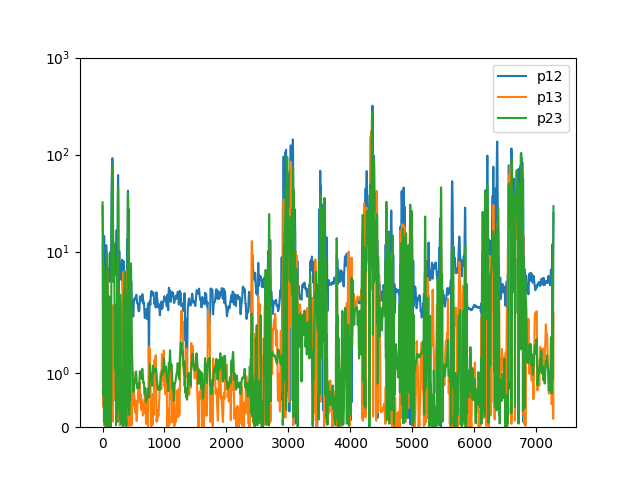

In [69]:
distance_r = np.array(distance)
plt.figure(0)
plt.plot(distance_r[:,0], label="p12")
plt.plot(distance_r[:,1], label="p13")
plt.plot(distance_r[:,2], label="p23")
#plt.plot(distance_r[:,3], label="m")
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
ax.set_ylim([0, 1000])
plt.show()

7280
10.134582526208469 3.719928618872109 5.297418821590249
19.66028367400942 9.753956481237672 14.35341263909884


<IPython.core.display.Javascript object>


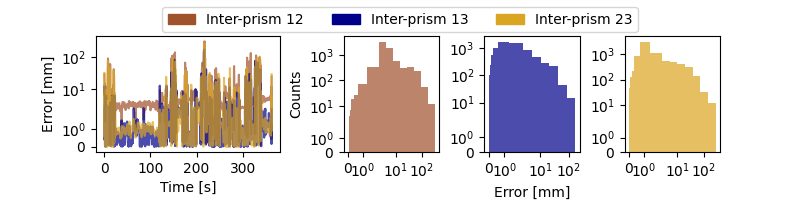

/home/norlab/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [70]:
import scripts.theodolite_plot_function as ptfuu
ptfuu = importlib.reload(ptfuu)
name_fig = "./figs/GP_data1_0_prism_error.pdf"
save = False
ptfuu.subplot_prisms_error(T_prediction, distance, save, name_fig)